In [ ]:
# default_exp trainer
# all_slow

In [ ]:
# hide
# skip
#!git clone https://github.com/marcomatteo/steel_segmentation.git
#!pip install -e steel_segmentation

# Trainer

> Training wrappers for Pytorch models with fastai Learner.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/nbs/07_trainer.ipynb)

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
from steel_segmentation.metadata import *
from steel_segmentation.masks import *
from steel_segmentation.datasets import *
from steel_segmentation.dataloaders import *
from steel_segmentation.metrics import *
from steel_segmentation.loss import *

from fastcore.foundation import *
from fastai.vision.all import *
import fastai

import os
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import segmentation_models_pytorch as smp

In [ ]:
# hide
only_imgs = ["0a1cade03.jpg", "bca4ae758.jpg", "988cf521f.jpg", "b6a257b28.jpg",
             "b2ad335bf.jpg", "72aaba8ad.jpg", "f383950e8.jpg"]
train = train[train["ImageId"].isin(only_imgs)].copy()
train_all = train_all[train_all["ImageId"].isin(only_imgs)].copy()
train_multi = train_multi[train_multi["ImageId"].isin(only_imgs)].copy()

## Pytorch Trainer

To start with Pytorch models I borrowed the code from [this kernel](https://www.kaggle.com/rishabhiitbhu/unet-starter-kernel-pytorch-lb-0-88) that works with `segmentation_models_pytorch`.

In [ ]:
# cuda
model = smp.Unet("resnet18", 
                 encoder_weights="imagenet", 
                 classes=4, 
                 activation=None)

In [ ]:
# export
class Trainer:
    '''This class takes care of training and validation of our model'''
    
    def __init__(self, model, save_path,
                 num_epochs=20, lr=5e-4, 
                 bs=16, num_workers=6):
        self.num_workers = num_workers
        self.batch_size = {"train": bs, "val": bs//2}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = lr
        self.num_epochs = num_epochs
        self.net = model
        self.save_path = save_path
        
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        
        self.dataloaders = {
            phase: get_train_dls(
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        """
        Forward pass: 
            load to GPU the imgs and masks,
            calculate predictions,
            calculate loss
        
        Returns:
            loss and predictions
        """
        images = images.to(self.device)
        masks = targets.to(self.device)
        preds = self.net(images)
        loss = self.loss_fn(preds, masks)
        return loss, preds

    def iterate(self, epoch, phase):
        """
        Iterate throught each batch in training or validation phase.
        """
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        
        running_loss = 0.0
        total_batches = len(dataloader)
#         tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader): # replace `dataloader` with `tk0` for tqdm
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
#             tk0.set_postfix(loss=(running_loss / ((itr + 1))))

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        """
        Training loop for each epochs.
        """
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss = self.iterate(epoch, "val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, self.save_path)
            print()

In [ ]:
# cuda
model_trainer = Trainer(model, path)

## Pytorch to fastai

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
arch = smp.Unet('resnet18', classes=4, activation=None, 
                encoder_weights='imagenet',
                decoder_attention_type='scse')

In [ ]:
dls = get_segmnt_dls(train_pivot.iloc[:32], bs=8, flatten_mask=False, device=device)

In [ ]:
x, targ = dls.one_batch()
x.shape, targ.shape

(torch.Size([8, 3, 256, 1600]), torch.Size([8, 4, 256, 1600]))

In [ ]:
x.device, targ.device

(device(type='cuda', index=0), device(type='cpu'))

The `fastai` training works with a custom Optimizer, to get that use a `opt_func` like:
```python
def opt_func(params, **kwargs): return OptimWrapper(torch.optim.Adam(params, **kwargs))
```

In [ ]:
# export
def convert_params(o:list) -> list:
    """
    Converts `o` into Pytorch-compatable param groups
    `o` should be a set of layer-groups that should be split in the optimizer
    
    Example:
    ```python
    def splitter(m): return convert_params([[m.a], [m.b]])
    ```
    
    Where `m` is a model defined as:
    ```python
    class RegModel(Module):
      def __init__(self): self.a,self.b = nn.Parameter(torch.randn(1)),nn.Parameter(torch.randn(1))
      def forward(self, x): return x*self.a + self.b
    ```
    
    Reference: [repo](https://github.com/muellerzr/fastai_minima).
    """
    if not isinstance(o[0], dict):
        splitter = []
        for group in o:
            if not isinstance(group[0], nn.parameter.Parameter):
                group = L(group).map(params)[0] # added [0] from original
            splitter.append({'params':group})
        return splitter
    return o

If we need to train a pretrained model and do properly transfer learning, we need a `splitter` like:
```python
def splitter(m): return convert_params([[m.encoder], [m.decoder]])
```

An example of `Learner`:

In [ ]:
def opt_func(params, **kwargs): return OptimWrapper(torch.optim.Adam(params, **kwargs))
def splitter(m): return convert_params([[m.encoder], [m.decoder], [m.segmentation_head]])

In [ ]:
learn = Learner(dls=dls, 
                model=arch, 
                loss_func=BCEWithLogitsLossFlat(axis=1),
                metrics=[ModDiceMulti, SingleDiceCoefChannel, Dices], 
                splitter=splitter, 
                opt_func=opt_func, 
                model_dir=models_dir, 
                cbs=[CudaCallback(), ShowGraphCallback()])

epoch,train_loss,valid_loss,mod_dice_multi,single_dice_coef_channel,dices,time
0,0.449154,0.576546,0.127991,0.044776,"(0.14285714285714285, 0.25, 0.0)",00:07
1,0.415785,0.482133,0.095231,0.040092,"(0.0, 0.0, 0.0)",00:07
2,0.387689,0.409326,0.057327,0.041020,"(0.5714285714285714, 1.0, 0.0)",00:07


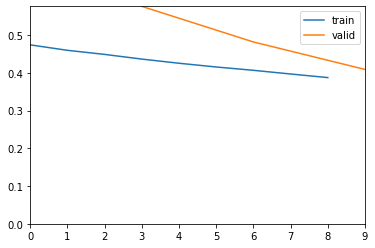

In [ ]:
learn.fit(3)

In [ ]:
learn.summary()

Unet (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 128 x 800  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                             

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.summary()

Unet (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 128 x 128  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                             

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_metadata.ipynb.
Converted 02_masks.ipynb.
Converted 03_datasets.ipynb.
Converted 04_dataloaders.ipynb.
Converted 05_metrics.ipynb.
Converted 06_loss.ipynb.
Converted 07_trainer.ipynb.
Converted 08_predict.ipynb.
Converted 09_visualize.ipynb.
Converted 10_fastai.classifier.ipynb.
Converted 11_fastai.seg_unet_resnet34.ipynb.
Converted 12_fastai.seg_unet_xresnext34.ipynb.
Converted 13_torch.seg_fpn_resnet34.ipynb.
Converted 14_torch.seg_unet_resnet34.ipynb.
Converted 15_torch.seg_unet_resnet18.ipynb.
Converted 21_ensemble_unet_fpn_resnet34.ipynb.
Converted index.ipynb.
